In [1]:
import numpy as np
import trimesh
import tqdm 

In [2]:
def uniform_sampling_from_mesh(vertices, faces, sample_num):
    # -------- TODO -----------
    # 1. compute area of each triangles
    # 2. compute probability of each triangles from areas
    # 3. sample N faces according to the probability
    # 4. for each face, sample 1 point
    # Note that FOR-LOOP is not allowed!
    # -------- TODO -----------
    # for a triangle ABC, its area can computed by |np.cross(vector(AB), vector(AC))| / 2.
    faces_axis = np.concatenate((vertices[faces[:, 0]], vertices[faces[:, 1]], vertices[faces[:, 2]]), axis=1).reshape(-1, 3, 3)
    area_plane = np.cross((faces_axis[:, 1] - faces_axis[:, 0]), (faces_axis[:, 2] - faces_axis[:, 0]))
    area = (np.sum(area_plane ** 2, axis=1) ** 0.5) / 2
    prob = area / np.sum(area)
    choose_idx = np.random.choice(faces_axis.shape[0], sample_num, p=prob)
    xy_noise = np.random.rand(sample_num, 2)
    proj_back_idx = np.where(np.sum(xy_noise, axis=1) > 1)[0]
    uniform_pc = xy_noise[:, 0][:, np.newaxis] * faces_axis[choose_idx, 0] \
                    + xy_noise[:, 1][:, np.newaxis] * faces_axis[choose_idx, 1] \
                    + (1 - np.sum(xy_noise, axis=1))[:, np.newaxis] *  faces_axis[choose_idx, 2]
    uniform_pc[proj_back_idx] = (1-xy_noise[proj_back_idx, 0])[:, np.newaxis] * faces_axis[choose_idx[proj_back_idx], 0] \
                                    + (1-xy_noise[proj_back_idx, 1])[:, np.newaxis] * faces_axis[choose_idx[proj_back_idx], 1] \
                                    + (np.sum(xy_noise[proj_back_idx], axis=1)-1)[:, np.newaxis] * faces_axis[choose_idx[proj_back_idx], 2]
                                    # 这里的因子应该是比slides上再减一          (^).
    return area, prob, uniform_pc
        

In [3]:
def farthest_point_sampling(pc, sample_num):
    # -------- TODO -----------
    # FOR LOOP is allowed here.
    # -------- TODO -----------
    start_point = np.random.randint(0, pc.shape[0])
    results_idx = [start_point]
    while len(results_idx) < sample_num:
        max_dis = -float('inf')
        max_idx = None
        results_point = pc[results_idx]
        for i in range(pc.shape[0]):
            if i not in results_idx:
                point = pc[i]
                dis = np.min(np.sum((point - results_point) ** 2, axis=1) ** 0.5)
                if dis > max_dis:
                    max_dis = dis
                    max_idx = i
        results_idx.append(max_idx)
    results = pc[results_idx]
    return results

In [4]:
# task 1: uniform sampling 

obj_path = 'spot.obj'
mesh = trimesh.load(obj_path)
print('faces shape: ', mesh.faces.shape)
sample_num = 512
area, prob, uniform_pc = uniform_sampling_from_mesh(mesh.vertices, mesh.faces, sample_num)

# Visualization. For you to check your code
np.savetxt('uniform_sampling_vis.txt', uniform_pc)

print('area shape: ',area.shape)
print('prob shape: ',prob.shape)
print('pc shape: ',uniform_pc.shape)
# the result should satisfy: 
#       area.shape = (13712, ) 
#       prob.shape = (13712, ) 
#       uniform_pc.shape = (512, 3) 

# For submission
save_dict = {'area': area, 'prob': prob, 'pc': uniform_pc}
np.save('../results/uniform_sampling_results', save_dict)

faces shape:  (13712, 3)
area shape:  (13712,)
prob shape:  (13712,)
pc shape:  (512, 3)


In [5]:
# task 2: FPS

init_sample_num = 2000
final_sample_num = 512
_,_, tmp_pc = uniform_sampling_from_mesh(mesh.vertices, mesh.faces, init_sample_num)
fps_pc = farthest_point_sampling(tmp_pc, final_sample_num)

# Visualization. For you to check your code
np.savetxt('fps_vis.txt', fps_pc)

# For submission
np.save('../results/fps_results', fps_pc)

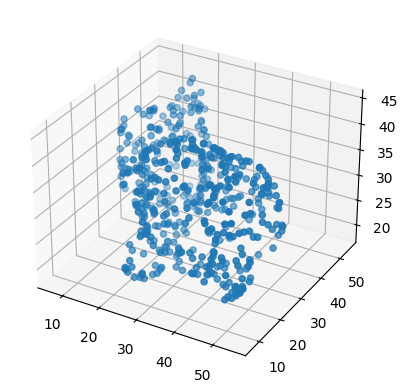

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
ax = plt.axes(projection='3d')
ax.scatter3D(uniform_pc[:,0], uniform_pc[:,1], uniform_pc[:,2] )

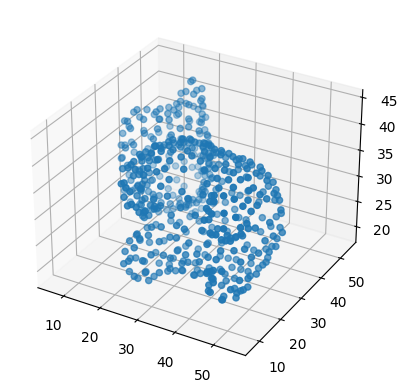

In [7]:
ax1 = plt.axes(projection='3d')
ax1.scatter3D(fps_pc[:,0], fps_pc[:,1], fps_pc[:,2] )

In [8]:
# task 3: metrics

from earthmover.earthmover import earthmover_distance   # EMD may be very slow (1~2mins)
# -----------TODO---------------
# compute chamfer distance and EMD for two point clouds sampled by uniform sampling and FPS.
# sample and compute CD and EMD again. repeat for five times.
# save the mean and var.
# -----------TODO---------------

CD_mean = 0
CD_var = 0
EMD_mean = 0
EMD_var = 0
def chamfer_dis(pc1, pc2):
    pc1 = pc1.reshape(-1, 1, 3)
    pc2 = pc2.reshape(1, -1, 3)
    dis = (pc1 - pc2) ** 2
    dis = np.sum(dis, axis=2) ** 0.5    
    result = np.sum(dis[np.arange(dis.shape[0]), np.argmin(dis, axis=1)]) / dis.shape[0] \
          + np.sum(dis[np.argmin(dis, axis=0), np.arange(dis.shape[1])]) / dis.shape[1]
    return result
CD_dis = []
EMD_dis = []
init_sample_num = 2000
final_sample_num = 512
for i in range(5):
    area, prob, uniform_pc = uniform_sampling_from_mesh(mesh.vertices, mesh.faces, final_sample_num)
    _,_, tmp_pc = uniform_sampling_from_mesh(mesh.vertices, mesh.faces, init_sample_num)
    fps_pc = farthest_point_sampling(tmp_pc, final_sample_num)

    CD_dis.append(chamfer_dis(uniform_pc, fps_pc))
    EMD_dis.append(earthmover_distance([tuple(x) for x in uniform_pc.tolist()], [tuple(x) for x in fps_pc.tolist()]))
CD_mean = np.mean(CD_dis)
EMD_mean = np.mean(EMD_dis)
CD_var = np.sum((CD_dis - CD_mean) ** 2) / len(CD_dis)
EMD_var = np.sum((EMD_dis - EMD_mean) ** 2) / len(EMD_dis)
# For submission
np.save('../results/metrics', {'CD_mean':CD_mean, 'CD_var':CD_var, 'EMD_mean':EMD_mean, 'EMD_var':EMD_var})

In [9]:
print(CD_mean, CD_var, EMD_mean, EMD_var)

2.7328536251458844 0.0010657157611594758 2.2027314515800533 0.004868984863660509
